# Panorama Stitching
---

### Om Shri Prasath EE17B113

## Importing the required libraries

- Numpy - For matrix manipulations
- Scipy - For interpolating image
- Matplotlib - For displaying image
- OpenCV - For computing SIFT features

> Note : The results of `get_features`, `match_keypoints`, `find_homography` & `transform_ransac` have been plotted together, along with the _homography matrix_ in a single cell. Refer to the cell for the outputs. Panorama has been plotted in a separate cell

In [1]:
# Note : Used for autoformatting the notebook, remove if causing any error
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from scipy.interpolate import griddata
import itertools

# To remove unnecessary warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
# Parameters for good matplotlib output

plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 6
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["legend.numpoints"] = 2
plt.rcParams["legend.loc"] = "best"
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "cm"
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}", r"\usepackage{amssymb}"]

<IPython.core.display.Javascript object>

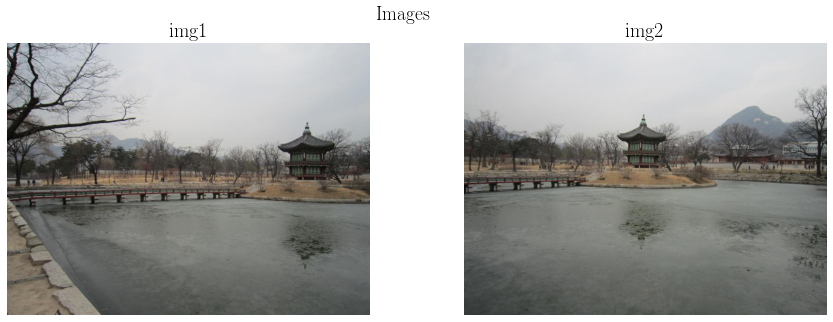

<IPython.core.display.Javascript object>

In [4]:
# Reading the images

img1 = plt.imread("img1.jpg")
img2 = plt.imread("img2.jpg")


# Function to plot images
def plot_imgs(img1, img2, title="Images"):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plt.suptitle(title)
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[0].set_title("img1")
    ax[1].set_title("img2")
    for a in ax:
        a.set_axis_off()
    plt.show()


plot_imgs(img1, img2)

## Compute SIFT Features and Match Keypoints

In [5]:
def get_sift_features(img):
    """
    Compute SIFT features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of SIFT descriptors
    """

    # Creating the SIFT detector and computer module
    sift = cv2.SIFT_create(nfeatures=5000)

    # Detecting the keypoints and computing the descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors

<IPython.core.display.Javascript object>

In [6]:
def match_keypoints(desc_1, desc_2, ratio=0.75):
    """
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
    """

    # Creating a Brute-Force keypoint matcher
    bf = cv2.BFMatcher()

    # Matching using k-nearest neighbours
    matches = bf.knnMatch(desc_1, desc_2, k=2)

    # Applying the ratio test on the matching points
    matches_ratio = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            matches_ratio.append(m)

    return matches_ratio

<IPython.core.display.Javascript object>

## Compute Homography Matrix using RANSAC

In [7]:
def find_homography(pts_1, pts_2):
    """
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_2: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
    """

    # Initializing the input-transformed matrix
    A = []

    # Creating the input-transformed matrix to apply SVD on
    for i in range(pts_1.shape[0]):
        xa, ya = pts_1[i]
        xb, yb = pts_2[i]
        A.append([-xa, -ya, -1, 0, 0, 0, xa * xb, ya * xb, xb])
        A.append([0, 0, 0, -xa, -ya, -1, xa * yb, ya * yb, yb])

    A = np.array(A)

    # Finding the SVD components
    U, S, V = np.linalg.svd(A)

    # Taking the eigenvector with least eigenvalue
    L = V[-1, :]

    # Reshaping the eigenvector to get the Homography Matrix
    H = L.reshape(3, 3)

    H = H / H[-1, -1]

    return H

<IPython.core.display.Javascript object>

In [8]:
def transform_ransac(pts_1, pts_2):
    """
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
    """

    # Creating homogeneous points for points in image 2
    pts_2_hmg = np.c_[pts_2, np.ones(pts_2.shape[0])]

    # Initializing best model
    best_model = np.zeros((3, 3))
    best_inliers_count = 0
    best_inliers = []

    # Setting the threshold for distance detection
    threshold = 0.1

    # Random samplings to get the best homography matrix
    for i in range(5000):

        # Sampling 4 random matching keypoints for computing homography matrix
        indices = random.sample(range(1, len(pts_1)), 4)

        # Finding the model using the above 4 keypoints
        model = find_homography(pts_2[indices, :], pts_1[indices, :])

        # Computing the transformed homogeneous points using the model
        pts_1_hmg_pred = np.matmul(pts_2_hmg, model.T)

        # Converting the homogeneous points to normal 2D points
        pts_1_pred = np.c_[
            pts_1_hmg_pred[:, 0] / pts_1_hmg_pred[:, 2],
            pts_1_hmg_pred[:, 1] / pts_1_hmg_pred[:, 2],
        ]

        # Counting the number of inliers
        inliers = np.sum((pts_1 - pts_1_pred) ** 2, axis=1) < threshold
        inliers_count = np.sum(inliers)

        # Checking if the current model is better than the best model via the number of inliers present
        if inliers_count > best_inliers_count:
            best_model = model
            best_inliers_count = inliers_count
            best_inliers = inliers

    best_model = find_homography(pts_2[best_inliers, :], pts_1[best_inliers, :])

    # Returning the best model
    return (best_model, best_inliers)

<IPython.core.display.Javascript object>

In [9]:
def panoramic_stitching(img1, img2, impose=0, plot_img=True):
    """
    Generate a panoramic image using the obtained homography matrix.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
    """

    # Finding the keypoints and descriptors from the images
    kp_1, desc_1 = get_sift_features(img1)
    kp_2, desc_2 = get_sift_features(img2)

    print("Number of keypoints in image 1 : ", len(kp_1))
    print("Number of keypoints in image 2 : ", len(kp_2))

    kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0, 255, 0), flags=0)
    kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0, 255, 0), flags=0)

    plot_imgs(kp_img1, kp_img2, "SIFT Keypoints of image")

    # Finding the matches from the images
    matches = match_keypoints(desc_1, desc_2)

    matches = np.array(matches)

    print("Number of matches : ", len(matches))

    # Visualizing the matches
    match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches, None, flags=2)

    plt.figure(figsize=(15, 7))
    plt.imshow(match_plot)
    plt.title("SIFT Feature Matches")
    plt.axis("off")
    plt.show()

    # Converting the cv2.keyPoints to image index list to get the list of matching indices in both images
    pts_1 = []
    pts_2 = []

    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        pts_1.append(np.array(kp_1[img1_idx].pt))
        pts_2.append(np.array(kp_2[img2_idx].pt))

    # Converting the points to numpy arrays
    pts_1 = np.array(pts_1)
    pts_2 = np.array(pts_2)

    # Getting the best model using RANSAC algorithm
    model, inliers = transform_ransac(pts_1, pts_2)

    print("Number of good matches after RANSAC : ", np.sum(inliers))

    # Plotting the match image plots
    match_plot = cv2.drawMatches(
        img1, kp_1, img2, kp_2, matches[inliers], None, flags=2
    )

    plt.figure(figsize=(15, 7))
    plt.imshow(match_plot)
    plt.title("SIFT Feature Matches after RANSAC")
    plt.axis("off")
    plt.show()

    # Printing homography matrix
    print("Homography Matrix :\n", model)

    # Getting the dimensions of the to-be-transformed image
    height, width, dim = img2.shape

    # Creating a meshgrid of indices of the to-be-transformed image
    x, y = np.mgrid[:width, :height]

    # Creating the set of indices to find the size of the transform of to-be-transformed image
    src_old = np.hstack(
        [x.reshape(-1, 1), y.reshape(-1, 1), np.ones((len(x.reshape(-1, 1)), 1))]
    )
    src_indices_old = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]).astype(int)

    # Calculating the size of the final panaromic image
    dst = np.matmul(src_old, model.T)
    dst_indices = np.round(
        np.c_[dst[:, 0] / dst[:, 2], dst[:, 1] / dst[:, 2]], 0
    ).astype(int)

    # Creating the final_img => Image which holds the panorama stitch output
    final_img = np.zeros(
        (
            max(img1.shape[0], dst_indices[:, 1].max()),
            max(img1.shape[1], dst_indices[:, 0].max()),
            dim,
        ),
        dtype=np.uint8,
    )

    # Inverting the Homography matrix (to do inverse interpolation of the to-be-transformed image)
    model_inv = np.linalg.inv(model)

    # Create indices for the final to-be-transformed image
    height_new, width_new, dim_new = final_img.shape

    # Creating a meshgrid of indices for the panaromic image
    x, y = np.mgrid[:width_new, :height_new]

    # Creating matrix for the final image
    l = len(x.reshape(-1, 1))

    # Creating the indices to map the second image to
    dst = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1), np.ones((l, 1))])
    dst_indices = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]).astype(int)

    # Finding the corresponding indices in the image to be transformed
    src = np.matmul(dst, model_inv.T)

    # Converting from homogeneous format to 2D format
    src_indices = np.c_[src[:, 0] / src[:, 2], src[:, 1] / src[:, 2]]

    # Filtering only the indices which are required for final panorama
    src_fin = src_indices[
        (src_indices[:, 0] >= 0)
        & (src_indices[:, 0] < img2.shape[1] - 1)
        & (src_indices[:, 1] >= 0)
        & (src_indices[:, 1] < img2.shape[0] - 1)
    ]
    dst_fin = dst_indices[
        (src_indices[:, 0] >= 0)
        & (src_indices[:, 0] < img2.shape[1] - 1)
        & (src_indices[:, 1] >= 0)
        & (src_indices[:, 1] < img2.shape[0] - 1)
    ]

    # Finding the values to fill in the panorama using interpolation
    img2_interp = griddata(
        (src_indices_old[:, 1], src_indices_old[:, 0]),
        img2[src_indices_old[:, 1], src_indices_old[:, 0]],
        (src_fin[:, 1], src_fin[:, 0]),
    )

    # Storing the image which is transformed to create panorama
    transformed_img = final_img.copy()

    # Creating the image which is transformed to apply the panorama
    transformed_img[dst_fin[:, 1], dst_fin[:, 0]] = img2_interp

    # Selecting which image to impose over which
    if impose == 0:

        # Inserting the transformed image first and then imposing the non-transformed image
        final_img[dst_fin[:, 1], dst_fin[:, 0]] = img2_interp
        final_img[: img1.shape[0], : img1.shape[1]] = img1

    else:

        # Inserting the non-transformed image first and then imposing the transformed image
        final_img[: img1.shape[0], : img1.shape[1]] = img1
        final_img[dst_fin[:, 1], dst_fin[:, 0]] = img2_interp

    # Converting to uint8 for correct image representation
    final_img = final_img.astype(np.uint8)

    print("\nCreated Panorama!")
    if plot_img:
        plt.figure(figsize=(15, 7))
        plt.title("Panorama Image", fontsize=25)
        plt.axis("off")
        plt.imshow(final_img)
        plt.show()

    return (transformed_img, final_img)

<IPython.core.display.Javascript object>

Number of keypoints in image 1 :  2232
Number of keypoints in image 2 :  1632


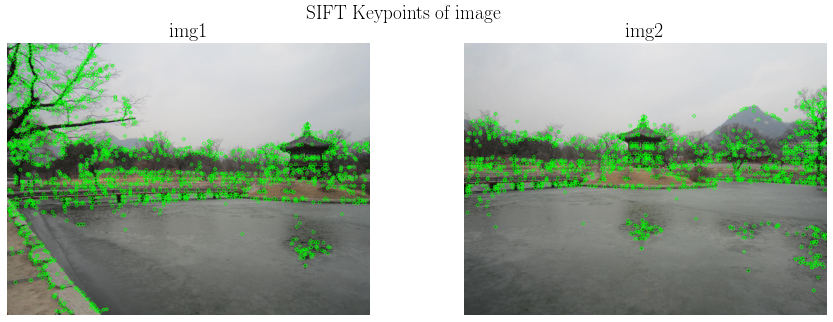

Number of matches :  396


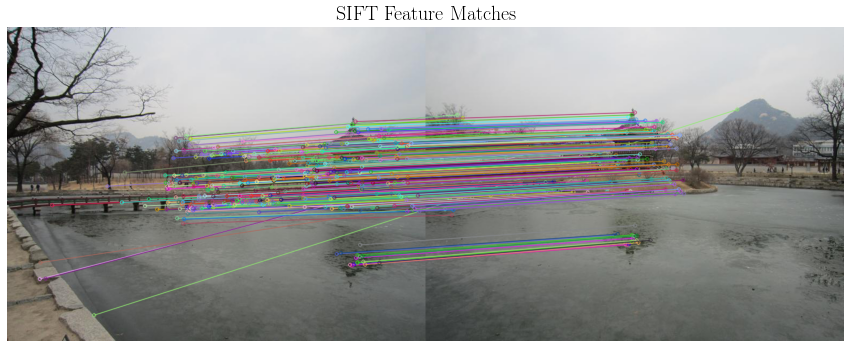

Number of good matches after RANSAC :  93


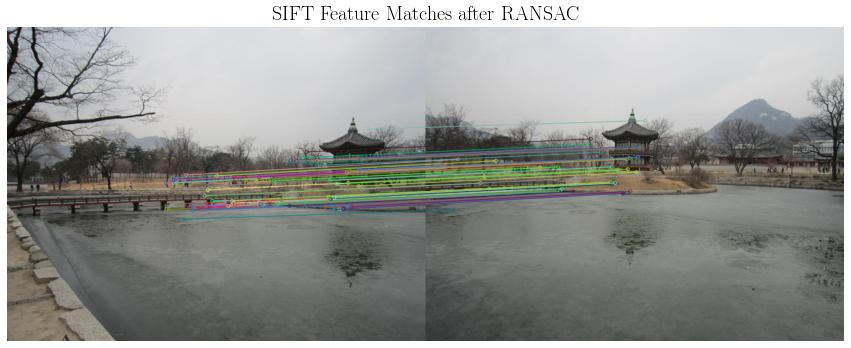

Homography Matrix :
 [[ 5.68363971e-01  3.13963425e-02  2.81496216e+02]
 [-1.66199990e-01  8.61682303e-01  6.46148790e+01]
 [-5.63570336e-04  1.91474280e-05  1.00000000e+00]]

Created Panorama!


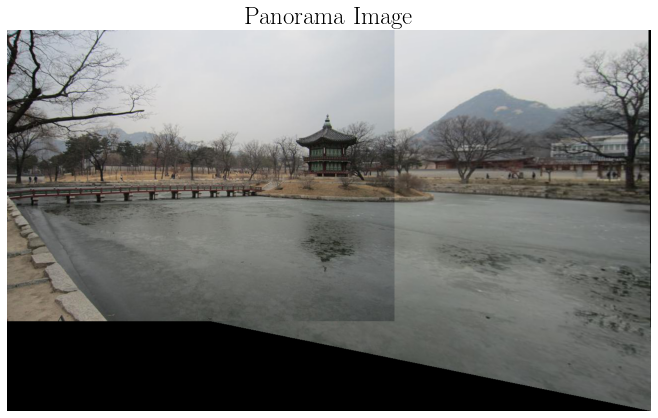

<IPython.core.display.Javascript object>

In [10]:
_, panorama = panoramic_stitching(img1, img2)

## Panorama with more than two images

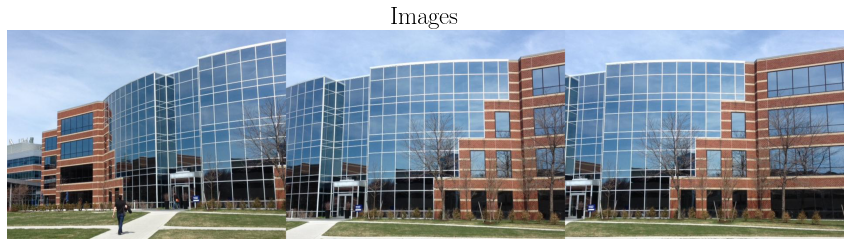

<IPython.core.display.Javascript object>

In [11]:
img_n_1 = plt.imread("image1.jpg")
img_n_2 = plt.imread("image2.jpg")
img_n_3 = plt.imread("image3.jpg")


plt.figure(figsize=(15, 7))
plt.imshow(np.hstack([img_n_1, img_n_2, img_n_3]))
plt.title("Images", fontsize=25)
plt.axis("off")
plt.show()

In [12]:
def strip_padding(img):

    while np.sum(img[0, :, :]) == 0:
        img = img[1:, :, :]

    while np.sum(img[-1, :, :]) == 0:
        img = img[:-1, :, :]

    while np.sum(img[:, 0, :]) == 0:
        img = img[:, 1:, :]

    while np.sum(img[:, -1, :]) == 0:
        img = img[:, :-1, :]

    return img

<IPython.core.display.Javascript object>

In [13]:
def three_image_panorama(images):

    # Raising error if more than 3 images are given
    if len(images) != 3:
        raise Exception("Number of images not 3")

    left = images[0]
    mid = images[1]
    right = images[2]

    print("\nCreating panorama of middle and left image!\n")

    # Appending the middle image in left with zeros to allow space in the right to fit transformed image
    mid_new = np.zeros((mid.shape[0], left.shape[1] + mid.shape[1], 3), dtype=np.uint8)
    mid_new[
        (mid_new.shape[0] - mid.shape[0]) // 2 : (mid_new.shape[0] + mid.shape[0]) // 2,
        -mid.shape[1] :,
    ] = mid

    # Creating the panorama with left and middle image
    res, _, = panoramic_stitching(mid_new, left, plot_img=False)

    # Imposing the middle image in the resulting panorama
    res[
        (mid_new.shape[0] - mid.shape[0]) // 2 : (mid_new.shape[0] + mid.shape[0]) // 2,
        -mid.shape[1] :,
    ] = mid

    # Stripping out the unwanted padding
    res = strip_padding(res)

    plt.figure(figsize=(15, 7))
    plt.title("Panorama Image", fontsize=25)
    plt.axis("off")
    plt.imshow(res)
    plt.show()

    print("\nCreating panorama of middle & left panorama with right image!\n")

    # Creating the panorama with the middle&left with the right image
    res = res[
        (res.shape[0] - mid.shape[0]) // 2 : (res.shape[0] + mid.shape[0]) // 2, :, :,
    ]
    _, res = panoramic_stitching(res, right, impose=1)

    plt.figure(figsize=(15, 7))
    plt.title("Panorama 3 Image", fontsize=25)
    plt.axis("off")
    plt.imshow(res)
    plt.show()

    return res

<IPython.core.display.Javascript object>


Creating panorama of middle and left image!

Number of keypoints in image 1 :  2248
Number of keypoints in image 2 :  2062


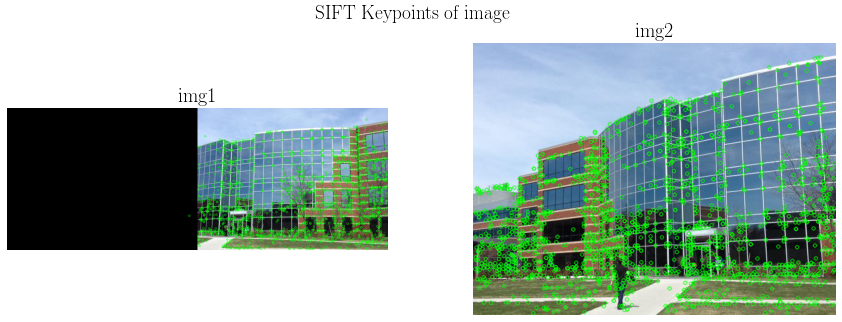

Number of matches :  405


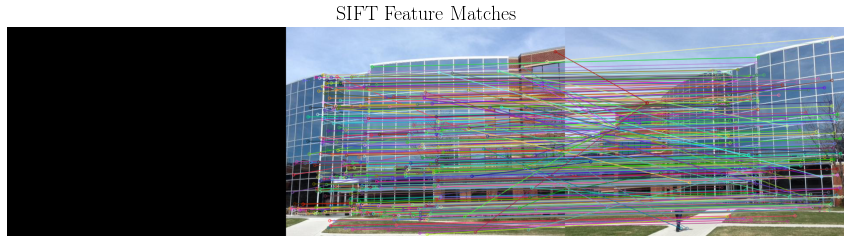

Number of good matches after RANSAC :  86


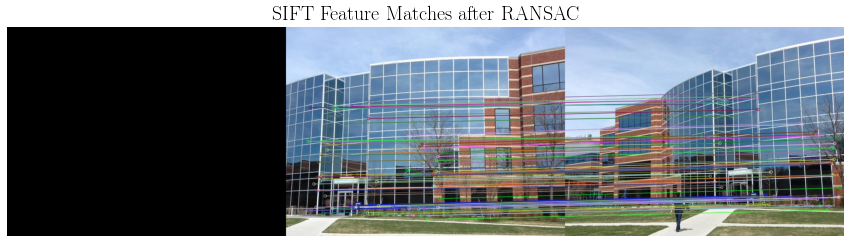

Homography Matrix :
 [[ 1.52694212e+00 -1.27276302e-01  3.28419542e+02]
 [ 1.89012461e-01  1.16418816e+00 -5.56600339e+01]
 [ 4.30721098e-04 -4.87771900e-05  1.00000000e+00]]

Created Panorama!


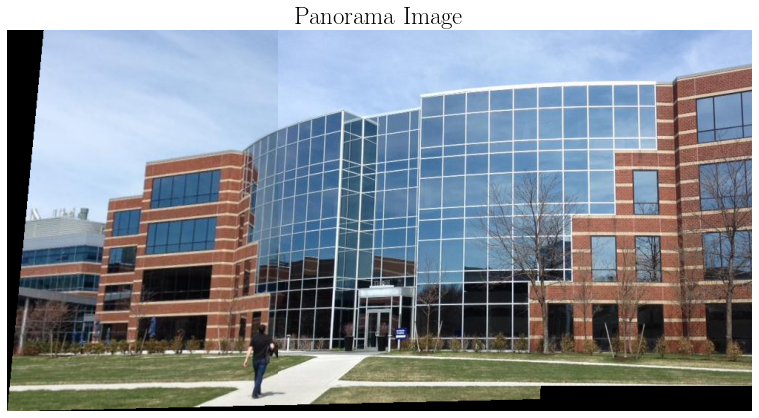


Creating panorama of middle & left panorama with right image!

Number of keypoints in image 1 :  3756
Number of keypoints in image 2 :  2265


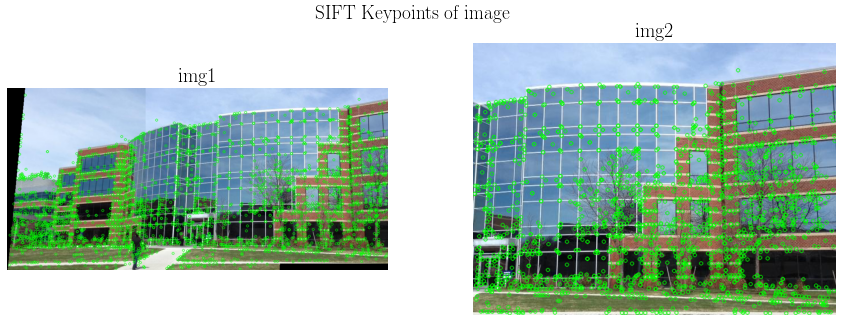

Number of matches :  860


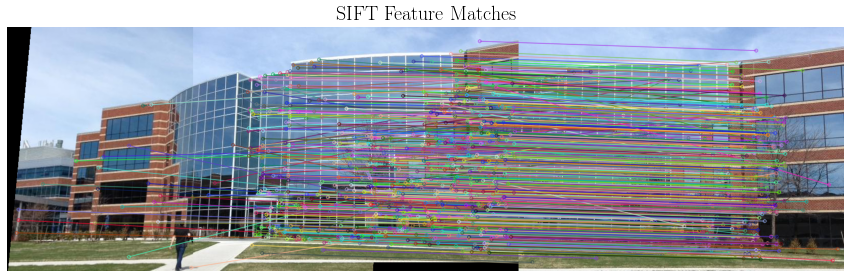

Number of good matches after RANSAC :  317


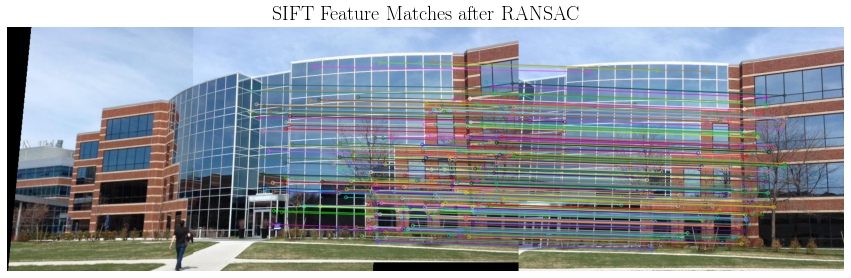

Homography Matrix :
 [[ 8.56608050e-01  1.10001591e-02  4.69411788e+02]
 [-4.89551926e-02  9.57810472e-01 -8.72275220e-01]
 [-1.43191589e-04 -5.41964360e-06  1.00000000e+00]]

Created Panorama!


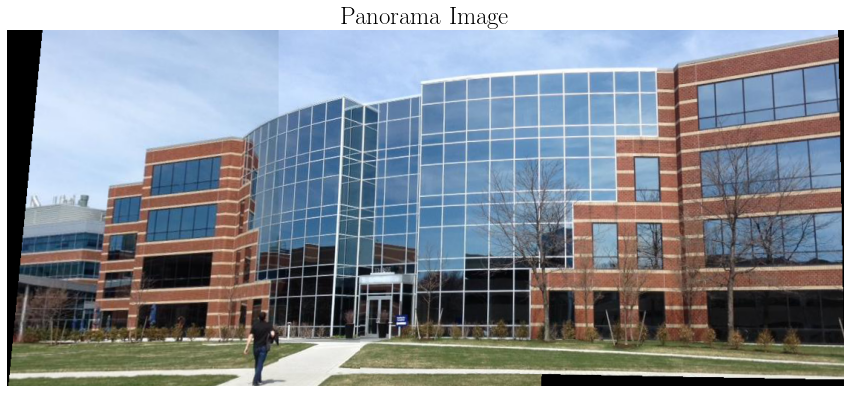

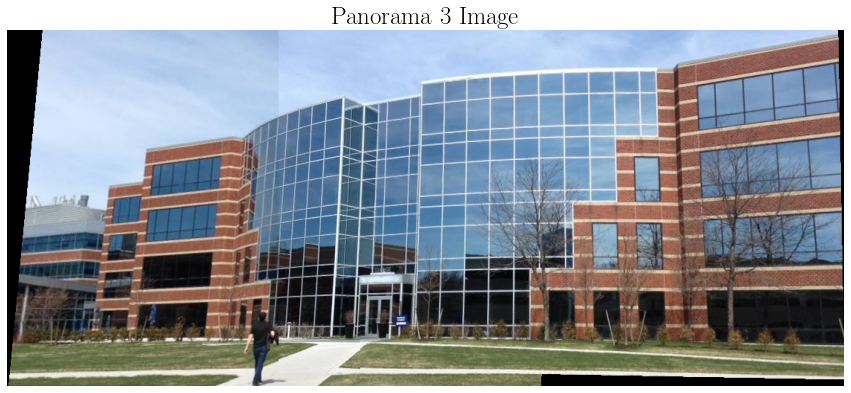

<IPython.core.display.Javascript object>

In [15]:
panorama_3 = three_image_panorama([img_n_1, img_n_2, img_n_3])